## 解密 DeepSeek 之  
## 完全从零实现的 MLA 算法
### Multi-Head Latent Attention
- 运行代码完全手写，一行一行带着运行，边写边知识点
- 欢迎阅读**chaofa用代码打点酱油**的
   - [博客原文](https://bruceyuan.com/post/hands-on-deepseek-mla-projection-absorption.html)
   - 实现稍有不一样，但原理是一样的，原因是一个是录制的过程中会有一些命名的改变
- 观看本视频之前，需要有一定的基础知识
   - 了解自注意力，self-attention
   - 了解 multi-head self-attention
   - 了解 Group Query Attention
   - 了解 kv cache 是什么

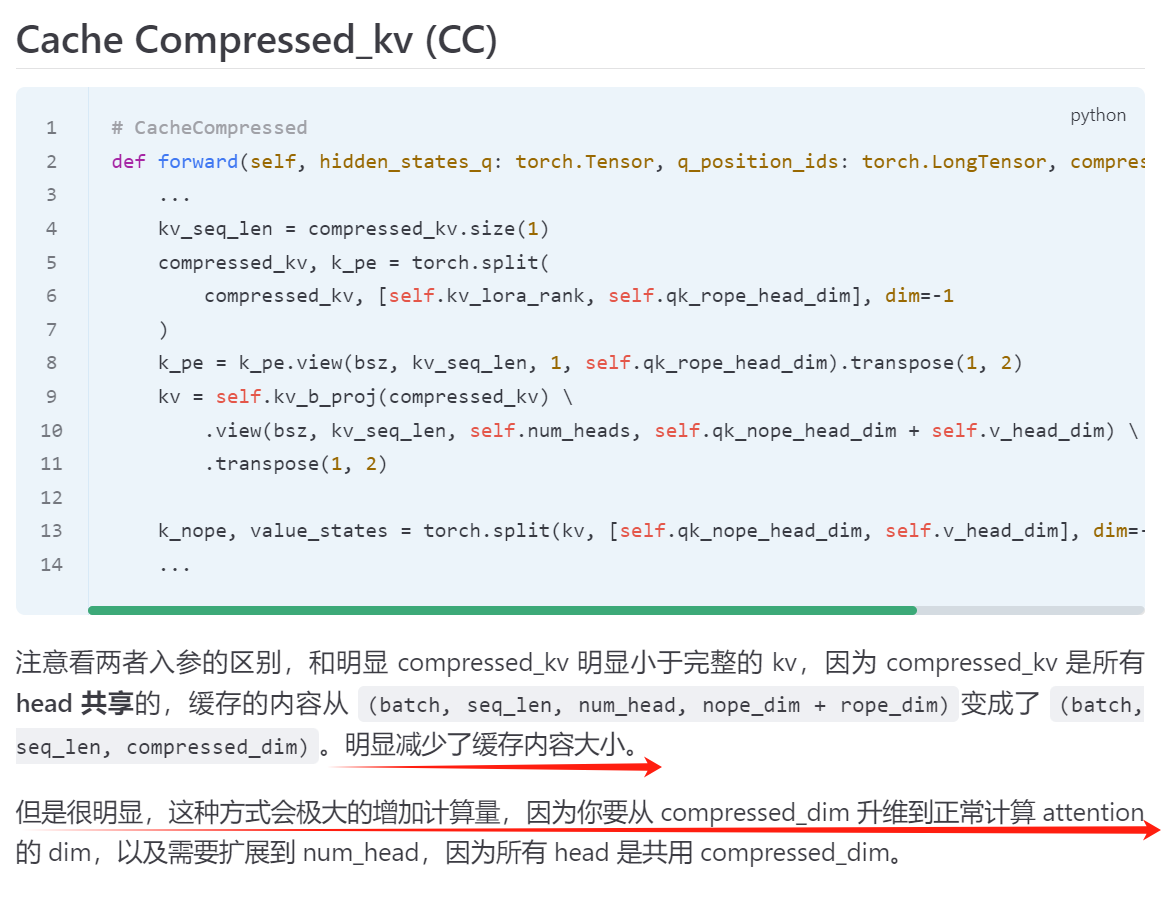

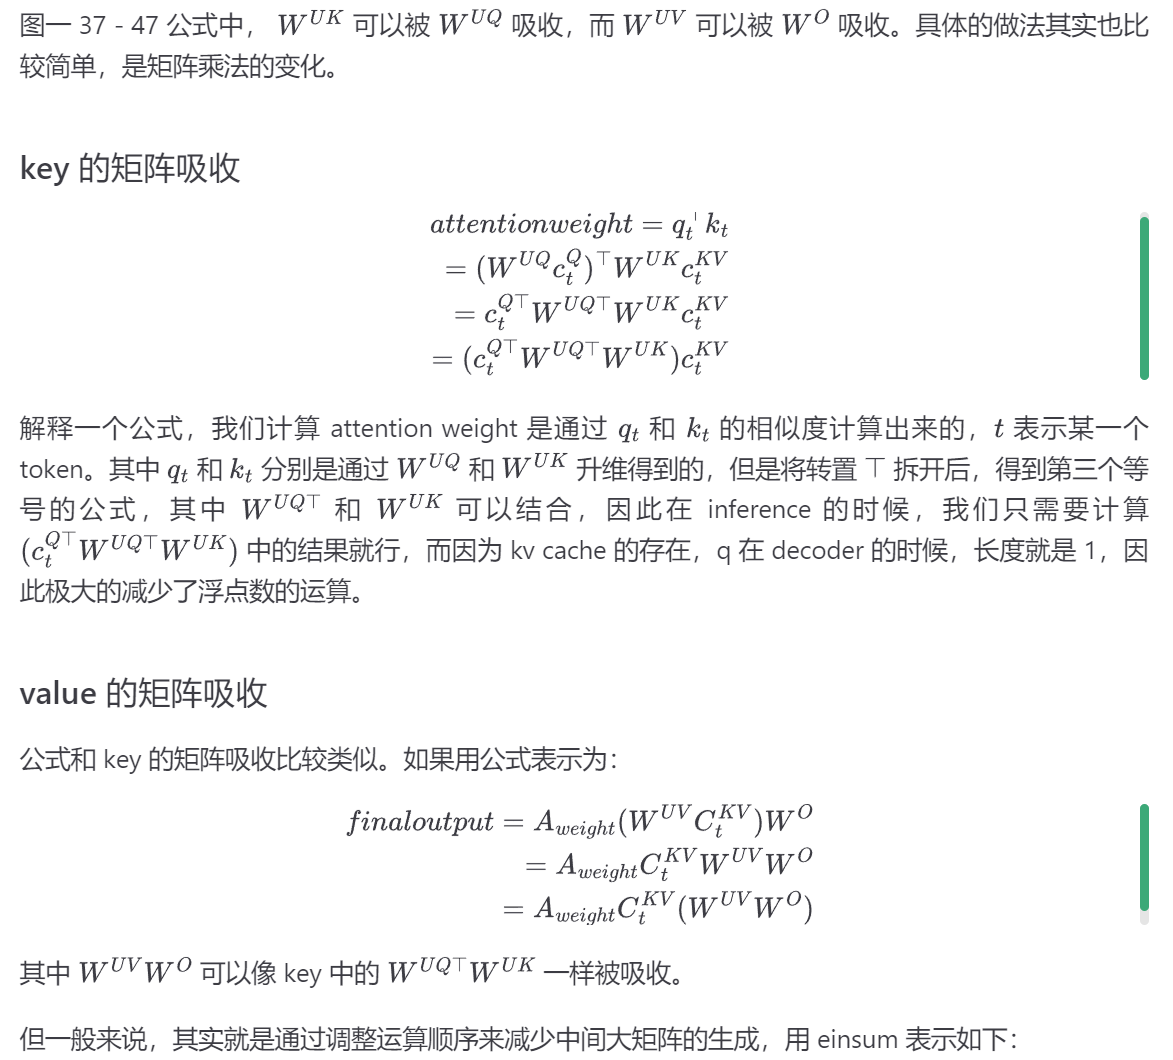

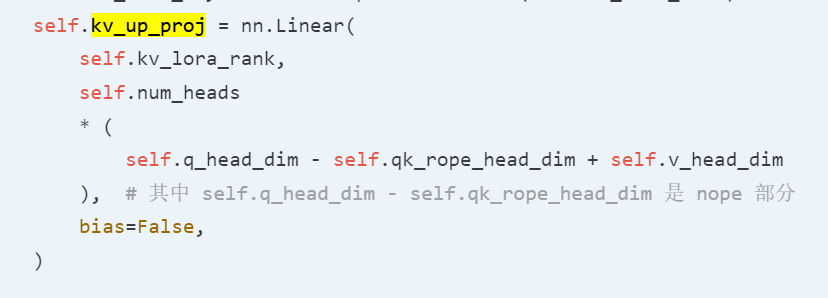

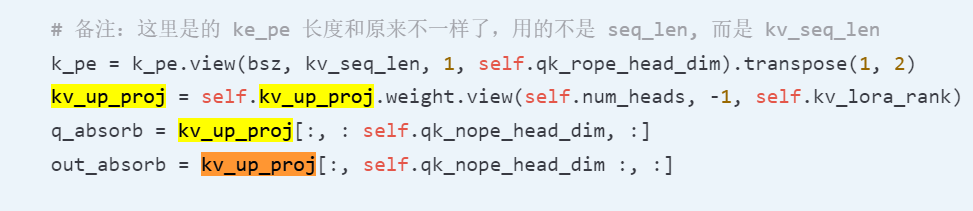

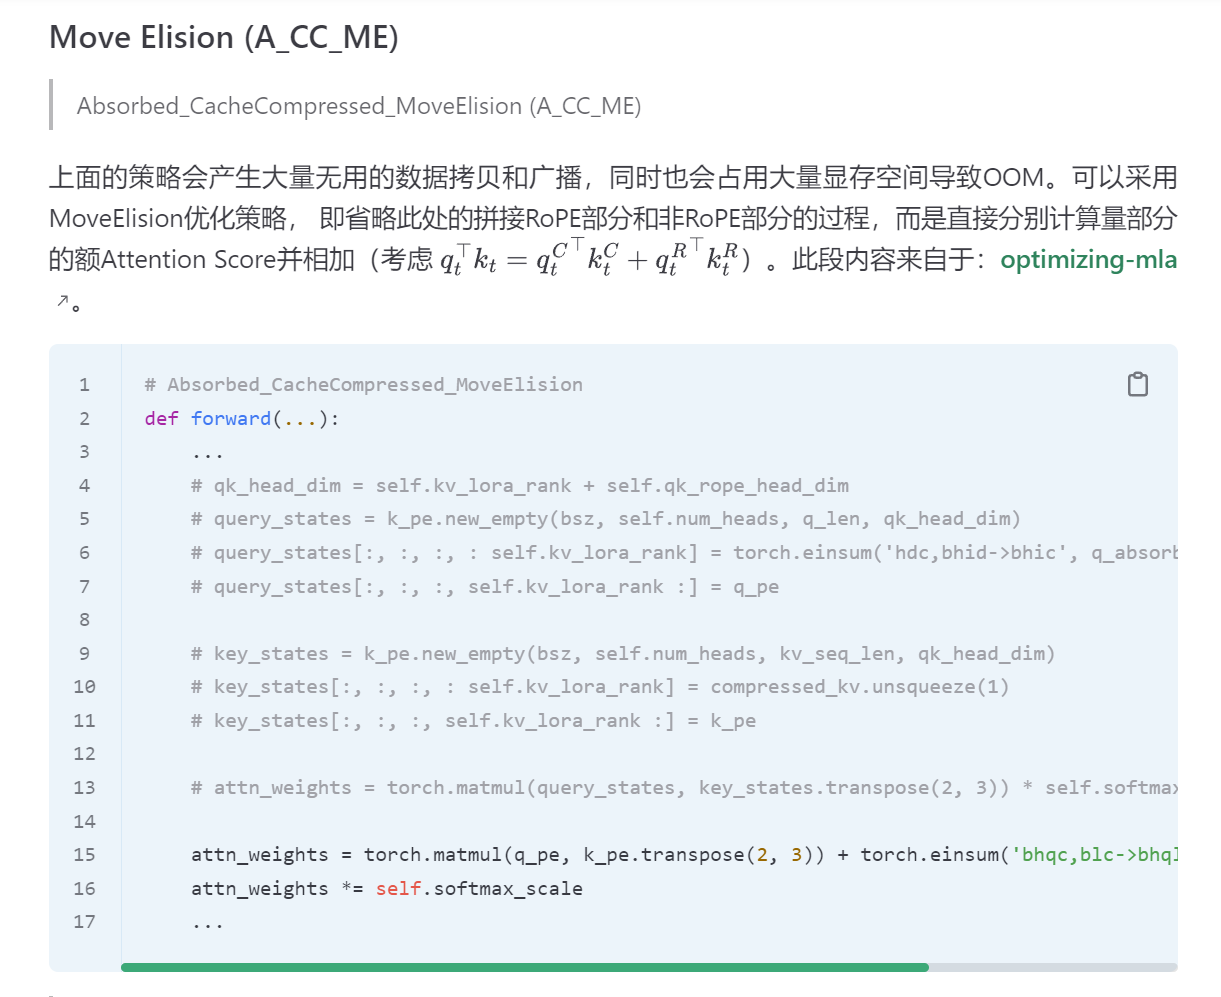


直接生成一个大矩阵 其中包括被吸收以后的两个大矩阵。这样原本需要四个矩阵 实际就要一个就可以了。注意只有q_nope和value是需要吸收的。q_rope是在进行运算以后再加上就可以了（因为rope是相乘的 这样吸收的矩阵之间会多两个R矩阵  所以rope是不吸收的）

nope 和 rope是可以直接相加的 没有必要再像原来一样拼接

In [5]:
# 基础的 package
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple
import math
from dataclasses import dataclass


# 一些前置代码，本次课暂时不涉及；
# 如果有需要，以后可以专门出视频讲解
class DeepseekV2RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states.to(input_dtype)


class DeepseekV2RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (
            self.base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim)
        )
        self.register_buffer("inv_freq", inv_freq, persistent=False)
        # 较小索引位置对应较低频率
        # 较大的索引位置有较高的频率

        # Build here to make `torch.jit.trace` work.
        self._set_cos_sin_cache(
            seq_len=max_position_embeddings,
            device=self.inv_freq.device,
            dtype=torch.get_default_dtype(),
        )
        self.max_seq_len_cached = max_position_embeddings

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        t = torch.arange(
            self.max_seq_len_cached, device=device, dtype=self.inv_freq.dtype
        )

        freqs = torch.outer(t, self.inv_freq.to(t.device))
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        if seq_len is not None and seq_len > self.max_seq_len_cached:
            print("seq_len:", seq_len, self.max_seq_len_cached)
            self._set_cos_sin_cache(seq_len=seq_len, device=x.device, dtype=x.dtype)

        return (
            self.cos_cached[:seq_len].to(dtype=x.dtype),
            self.sin_cached[:seq_len].to(dtype=x.dtype),
        )


# Copied from transformers.models.llama.modeling_llama.rotate_half
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


# Copied from transformers.models.llama.modeling_llama.apply_rotary_pos_emb
def apply_rotary_pos_emb(q, k, cos, sin, position_ids, unsqueeze_dim=1):
    cos = cos[position_ids].unsqueeze(unsqueeze_dim)
    sin = sin[position_ids].unsqueeze(unsqueeze_dim)

    b, h, s, d = q.shape
    q = q.view(b, h, s, d // 2, 2).transpose(4, 3).reshape(b, h, s, d)

    b, h, s, d = k.shape
    k = k.view(b, h, s, d // 2, 2).transpose(4, 3).reshape(b, h, s, d)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


# Copied from transformers.models.llama.modeling_llama.apply_rotary_pos_emb
def apply_rotary_pos_emb_v2(q: torch.Tensor, cos, sin, position_ids, unsqueeze_dim=1):
    cos = cos[position_ids].unsqueeze(unsqueeze_dim)
    sin = sin[position_ids].unsqueeze(unsqueeze_dim)

    b, h, s, d = q.shape
    q = q.view(b, h, s, d // 2, 2).transpose(4, 3).reshape(b, h, s, d)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    return q_embed

In [6]:
from dataclasses import dataclass


@dataclass
class DeepseekConfig:
    hidden_size: int
    num_heads: int
    max_position_embeddings: int
    rope_theta: float
    attention_dropout: float

    q_lora_rank: int
    qk_rope_head_dim: int
    kv_lora_rank: int
    v_head_dim: int
    qk_nope_head_dim: int
    attention_bias: bool

In [7]:
"""
这是带有矩阵吸收的版本
"""


class MLAV2(nn.Module):
    def __init__(
        self,
        config,
    ):
        super().__init__()

        self.attention_dropout = config.attention_dropout
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads

        self.max_postion_embeddings = config.max_position_embeddings
        self.rope_theta = config.rope_theta

        # 对应 query 压缩的向量， 在 deepseek v3 中， hidden_size 7168
        # 但是压缩后的 kv d_c= 512，压缩比例 1/14
        # q 的压缩为 1536 压缩比例 1/4.7
        # rope 部分是 64

        self.q_lora_rank = config.q_lora_rank
        # 对应 query 和 key 进行 rope 的维度
        self.qk_rope_head_dim = config.qk_rope_head_dim
        # 对应 value 压缩的向量
        self.kv_lora_rank = config.kv_lora_rank

        # 对应 每一个 Head 的维度大小
        self.v_head_dim = config.v_head_dim

        self.qk_nope_head_dim = config.qk_nope_head_dim
        self.q_head_dim = config.qk_nope_head_dim + config.qk_rope_head_dim

        self.q_down_proj = nn.Linear(
            self.hidden_size,
            self.q_lora_rank,
            bias=config.attention_bias,
        )
        self.q_down_layernorm = DeepseekV2RMSNorm(self.q_lora_rank)

        self.q_up_proj = nn.Linear(
            self.q_lora_rank,
            self.num_heads * self.q_head_dim,
            # 最终还需要做切分（split），一部分是 nope，一部分需要应用 rope
            bias=False,
        )

        # 同理对于 kv 也是一样的
        self.kv_down_proj = nn.Linear(
            self.hidden_size,
            self.kv_lora_rank + self.qk_rope_head_dim,
            bias=config.attention_bias,
        )
        self.kv_down_layernorm = DeepseekV2RMSNorm(self.kv_lora_rank)
        self.kv_up_proj = nn.Linear(
            self.kv_lora_rank,
            self.num_heads
            * (
                self.q_head_dim - self.qk_rope_head_dim + self.v_head_dim
            ),  # 其中 self.q_head_dim - self.qk_rope_head_dim 是 nope 部分
            bias=False,
        )

        # 对应公式 47 行
        self.o_proj = nn.Linear(
            self.num_heads * self.v_head_dim,
            self.hidden_size,
            bias=config.attention_bias,
        )

        # 初始化 rope 的参数
        self.rotary_emb = DeepseekV2RotaryEmbedding(
            self.qk_rope_head_dim,
            self.max_postion_embeddings,
            self.rope_theta,
        )

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        compressed_kv: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """
        MLA (Multi-head Linearized Attention) forward pass
        """
        bsz, q_len, _ = hidden_states.size()

        # 1. Query projection and split
        q = self.q_up_proj(self.q_down_layernorm(self.q_down_proj(hidden_states)))
        q = q.view(bsz, q_len, self.num_heads, self.q_head_dim).transpose(1, 2)
        q_nope, q_pe = torch.split(
            q, [self.qk_nope_head_dim, self.qk_rope_head_dim], dim=-1
        )

        # 2. Key/Value projection and split
        kv_seq_len = compressed_kv.size(1)
        compressed_kv, k_pe = torch.split(
            compressed_kv, [self.kv_lora_rank, self.qk_rope_head_dim], dim=-1
        )

        # 备注：这里是的 ke_pe 长度和原来不一样了，用的不是 seq_len, 而是 kv_seq_len
        k_pe = k_pe.view(bsz, kv_seq_len, 1, self.qk_rope_head_dim).transpose(1, 2)
        kv_up_proj = self.kv_up_proj.weight.view(self.num_heads, -1, self.kv_lora_rank)
        q_absorb = kv_up_proj[:, : self.qk_nope_head_dim, :]
        out_absorb = kv_up_proj[:, self.qk_nope_head_dim :, :]

        # 3. Apply RoPE to position-dependent parts
        print("q_pe shape:", q_pe.shape)

        cos, sin = self.rotary_emb(q_pe)
        q_pe = apply_rotary_pos_emb_v2(q_pe, cos, sin, position_ids)
        print("k_pe shape:", k_pe.shape)
        print("k pe mT shape:", k_pe.mT.shape)
        print("compressed_kv shape:", compressed_kv.shape)
        print("q_nope shape:", q_nope.shape)
        print("torch.matmul(q_pe, k_pe.mT) shape", torch.matmul(q_pe, k_pe.mT).shape)
        q_nope = torch.matmul(q_nope, q_absorb)
        attn_weights = (
            torch.matmul(q_pe, k_pe.mT)
            + torch.matmul(q_nope, compressed_kv.unsqueeze(-3).mT)
        ) / math.sqrt(self.q_head_dim)
        attn_weights = nn.functional.softmax(
            attn_weights, dim=-1, dtype=torch.float32
        ).to(q_nope.dtype)
        # shape is : (bsz, self.num_heads, q_len, kv_seq_len)

        # 2. Compute attention output
        attn_output = torch.einsum("bhql,blc->bhqc", attn_weights, compressed_kv)
        attn_output = torch.matmul(
            attn_output, out_absorb.mT
        )  # # torch.einsum('bhqc,hdc->bhqd', attn_output, out_absorb)
        attn_output = attn_output.transpose(1, 2).reshape(bsz, q_len, -1)
        attn_output = self.o_proj(attn_output)

        return attn_output, attn_weights


# 写一个测试函数
def test_mlav2():
    config = DeepseekConfig(
        hidden_size=7168,
        num_heads=16,
        max_position_embeddings=1024,
        rope_theta=128000,
        attention_dropout=0.1,
        q_lora_rank=1536,
        qk_rope_head_dim=64,
        kv_lora_rank=512,
        v_head_dim=128,
        qk_nope_head_dim=128,
        attention_bias=False,
    )
    # 测试 MLAv2 attention
    # 生成 compressed_kv 的步骤:
    # 1. 先生成原始的 kv hidden states, shape 是 [bsz, kv_seq_len, hidden_size]
    # 2. 用 kv_a_proj_with_mqa 投影到 [bsz, kv_seq_len, kv_lora_rank + qk_rope_head_dim]
    # 3. split 成 compressed_kv 和 k_pe 两部分
    # 4. compressed_kv 过 layernorm
    # 5. k_pe 过 RoPE
    # 6. 最后把 compressed_kv 和 k_pe concat 在一起

    bsz = 2
    q_len = 1
    kv_seq_len = 12
    hidden_size = config.hidden_size

    # 生成测试数据
    q = torch.randn(bsz, q_len, hidden_size).cuda()
    # position_ids = torch.arange(q_len).expand(bsz, -1).cuda()
    position_ids = torch.full((bsz, q_len), 12, dtype=torch.long).cuda()

    # 初始化模型
    model = MLAV2(config).cuda()

    # 先随机初始化一个 compressed_kv
    compressed_kv = torch.randn(
        bsz, kv_seq_len, config.kv_lora_rank + config.qk_rope_head_dim
    ).cuda()
    print(
        "compressed_kv shape:", compressed_kv.shape
    )  # [bsz, kv_seq_len, kv_lora_rank + qk_rope_head_dim]

    # 前向计算
    output, attn_weights = model(q, None, position_ids, compressed_kv)
    print("output shape:", output.shape)  # [bsz, q_len, hidden_size]
    print(
        "attn_weights shape:", attn_weights.shape
    )  # [bsz, num_heads, q_len, kv_seq_len]


test_mlav2()

compressed_kv shape: torch.Size([2, 12, 576])
q_pe shape: torch.Size([2, 16, 1, 64])
k_pe shape: torch.Size([2, 1, 12, 64])
k pe mT shape: torch.Size([2, 1, 64, 12])
compressed_kv shape: torch.Size([2, 12, 512])
q_nope shape: torch.Size([2, 16, 1, 128])
torch.matmul(q_pe, k_pe.mT) shape torch.Size([2, 16, 1, 12])
output shape: torch.Size([2, 1, 7168])
attn_weights shape: torch.Size([2, 16, 1, 12])


In [8]:
# a = torch.randn(2, 16, 2, 64)
# b = torch.randn(2, 16, 64, 128)
# torch.matmul(a, b).shape

# torch.full((2, 16, 2, 64), 129, dtype=torch.long).cuda()
torch.arange(0, 12)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])